<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/HMM_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hmmlearn


     |████████████████████████████████| 368kB 2.6MB/s 


In [3]:
import numpy as np
import hmmlearn.hmm as hmm

In [4]:
# 定义变量
states = ['盒子1', '盒子2', '盒子3']
obs = ['白球', '黑球']
n_states = len(states)
m_obs = len(obs)
start_probability = np.array([0.2, 0.5, 0.3])
transition_probability = np.array([
    [0.5, 0.4, 0.1],
    [0.2, 0.2, 0.6],
    [0.2, 0.5, 0.3]
])
emission_probalitity = np.array([
    [0.4, 0.6],
    [0.8, 0.2],
    [0.5, 0.5]
])

In [5]:
# 定义模型
model = hmm.MultinomialHMM(n_components=n_states)
model.startprob_ = start_probability
model.transmat_ = transition_probability
model.emissionprob_ = emission_probalitity

In [7]:
# 运行viterbi预测的问题
se = np.array([[0, 1, 0, 0, 1]]).T
logprod, box_index = model.decode(se, algorithm='viterbi')

In [8]:
print("颜色:", end="")
print(" ".join(map(lambda t: obs[t], [0, 1, 0, 0, 1])))
print("盒子:", end="")
print(" ".join(map(lambda t: states[t], box_index)))
print("概率值:", end="")
print(np.exp(logprod)) # 这个是因为在hmmlearn底层将概率进行了对数化，防止出现乘积为0的情况

颜色:白球 黑球 白球 白球 黑球
盒子:盒子2 盒子3 盒子2 盒子2 盒子3
概率值:0.002304


In [15]:
# 使用MultinomialHMM进行参数的训练
model2 = hmm.MultinomialHMM(n_components=n_states, n_iter=20, tol=0.001)
X2 = np.array([
    [0, 1, 0, 0, 1],
    [0, 0, 0, 1, 1],
    [1, 1, 0, 1, 0],
    [0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0]
])
model2.fit(X2)
print("输出根据数据训练出来的π")
print(model2.startprob_)
print("输出根据数据训练出来的A")
print(model2.transmat_)
print("输出根据数据训练出来的B")
print(model2.emissionprob_)

输出根据数据训练出来的π
[3.22678072e-06 9.99996773e-01 5.53209156e-16]
输出根据数据训练出来的A
[[0.30480189 0.40789402 0.28730409]
 [0.16999989 0.14362155 0.68637856]
 [0.48047577 0.33944751 0.18007672]]
输出根据数据训练出来的B
[[0.64024636 0.35975364]
 [0.96495917 0.03504083]
 [0.12156227 0.87843773]]


In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics.pairwise import pairwise_distances_argmin
import warnings

In [18]:
%matplotlib inline

In [19]:
def expand(a, b):
    return 1.05*a-0.05*b, 1.05*b-0.05*a

warnings.filterwarnings("ignore")
np.random.seed(28)
n = 5   # 隐状态数目
n_samples = 500 # 样本数量

In [20]:
pi = np.random.rand(n)
pi /= pi.sum()
print('初始概率：')
print(pi)

初始概率：
[0.28102534 0.21635059 0.04817319 0.1532667  0.30118418]


In [21]:
A = np.random.rand(n, n)
mask = np.zeros((n, n), dtype=np.bool)
mask[0][1] = mask[0][4] = True
mask[1][0] = mask[1][2] = True
mask[2][1] = mask[2][3] = True
mask[3][2] = mask[3][4] = True
mask[4][0] = mask[4][3] = True
A[mask] = 0
for i in range(n):
    A[i] /= A[i].sum()
print('转移概率:')
print(A)

转移概率:
[[0.2202672  0.         0.36791287 0.41181993 0.        ]
 [0.         0.4995834  0.         0.01356202 0.48685458]
 [0.57655791 0.         0.10400763 0.         0.31943446]
 [0.23695178 0.33043766 0.         0.43261056 0.        ]
 [0.         0.58044648 0.15883558 0.         0.26071794]]


In [23]:
# 给定均值（n*feature_number的一个矩阵, n表示隐状态，feature_number表示观测值中样本的特征数目）
means = np.array(((30, 30, 30), (0, 50, 20), (-25, 30, 10), (-15, 0, 25), (15, 0, 40)), dtype=np.float)
print(means)
for i in range(n):
    means[i,:] /= np.sqrt(np.sum(means ** 2, axis=1))[i]
print('均值：')
print(means)

[[ 30.  30.  30.]
 [  0.  50.  20.]
 [-25.  30.  10.]
 [-15.   0.  25.]
 [ 15.   0.  40.]]
均值：
[[ 0.57735027  0.57735027  0.57735027]
 [ 0.          0.92847669  0.37139068]
 [-0.62017367  0.74420841  0.24806947]
 [-0.51449576  0.          0.85749293]
 [ 0.35112344  0.          0.93632918]]


In [24]:
# 给定方差（n*feature_number*feature_number的一个矩阵, n表示隐状态，feature_number表示观测值中样本的特征数目）
covars = np.empty((n, 3, 3))
print(covars)
for i in range(n):
    covars[i] = np.diag(np.random.rand(3)*0.02+0.001)    # np.random.rand ∈[0,1)
print('方差：\n')
print(covars)


[[[ 1.85429714e-316  5.07565891e-317  1.59583204e-321]
  [             nan -3.72294989e-180 -3.51746338e-015]
  [ 6.12026390e+257  2.38954692e+180  2.28895451e+243]]

 [[ 1.14073631e+243 -1.23396867e-034  2.58845801e-093]
  [-3.37737147e-026 -2.58755735e-304  3.98564098e+252]
  [ 1.35712994e+166 -3.37737147e-026 -2.45457267e-304]]

 [[-6.42560237e+186 -1.59647988e-031 -2.99318583e-174]
  [ 3.08854819e+262  3.74168445e+233  3.10573437e-115]
  [ 3.18110756e-110  8.29655075e-114  1.03456549e-259]]

 [[ 7.26608699e+223  4.40927704e+222  3.04284970e+169]
  [ 9.66295130e+141  4.82745794e+199  2.55614266e+161]
  [ 5.04502340e+223  1.30354947e-076  2.85885996e-110]]

 [[ 3.74163517e+233  4.73496898e-085 -1.50723842e-267]
  [ 1.71124626e+243 -2.82252398e-031  4.13590288e+223]
  [ 6.96770841e+252  5.17523075e-109 -1.14789829e-164]]]
方差：

[[[0.0155071  0.         0.        ]
  [0.         0.02010293 0.        ]
  [0.         0.         0.00246192]]

 [[0.00994326 0.         0.        ]
  [0.     

In [25]:
# 产生对应的模拟数据
model = hmm.GaussianHMM(n_components=n, covariance_type='full')
model.startprob_ = pi
model.transmat_ = A
model.means_ = means
model.covars_ = covars
sample, labels = model.sample(n_samples=n_samples, random_state=0)

In [26]:
# 模型构建及估计参数
model = hmm.GaussianHMM(n_components=n, covariance_type='full', n_iter=10)
model.fit(sample)
y = model.predict(sample)
np.set_printoptions(suppress=True)
print('##估计初始概率：')
print(model.startprob_)
print('##估计转移概率：')
print(model.transmat_)
print('##估计均值：\n')
print(model.means_)
print('##估计方差：\n')
print(model.covars_)

##估计初始概率：
[0. 0. 0. 1. 0.]
##估计转移概率：
[[0.11627698 0.39536037 0.         0.         0.48836266]
 [0.16234284 0.22727269 0.61038447 0.         0.        ]
 [0.         0.45175252 0.53070356 0.01754392 0.        ]
 [0.         0.         0.31707317 0.48780488 0.19512195]
 [0.39393889 0.         0.         0.48484889 0.12121222]]
##估计均值：

[[-0.66623282  0.72555432  0.24210984]
 [ 0.34487731 -0.00195664  0.93881753]
 [-0.00362742  0.92283229  0.37226363]
 [-0.5168573   0.00094903  0.85695108]
 [ 0.55697474  0.62964013  0.5667117 ]]
##估计方差：

[[[ 0.01673939 -0.00116631 -0.00104601]
  [-0.00116631  0.01308765 -0.00160787]
  [-0.00104601 -0.00160787  0.01618941]]

 [[ 0.00580409 -0.0000912   0.00069388]
  [-0.0000912   0.02026833 -0.0012663 ]
  [ 0.00069388 -0.0012663   0.01309224]]

 [[ 0.00893018 -0.00036242  0.00004194]
  [-0.00036242  0.0146526   0.00006488]
  [ 0.00004194  0.00006488  0.00340065]]

 [[ 0.00341816 -0.0004482   0.00132588]
  [-0.0004482   0.00196013  0.00027713]
  [ 0.001325

In [27]:
# 根据类别信息更改顺序
order = pairwise_distances_argmin(means, model.means_, metric='euclidean')
print(order)
pi_hat = model.startprob_[order]
A_hat = model.transmat_[order]
A_hat = A_hat[:, order]
means_hat = model.means_[order]
covars_hat = model.covars_[order]
change = np.empty((n, n_samples), dtype=np.bool)
for i in range(n):
    change[i] = y == order[i]
for i in range(n):
    y[change[i]] = i
print('估计初始概率：')
print(pi_hat)
print('估计转移概率：')
print(A_hat)
print('估计均值：')
print(means_hat)
print('估计方差：')
print(covars_hat)
print(labels)
print(y)
acc = np.mean(labels == y) * 100
print('准确率：%.2f%%' % acc)

[4 2 0 3 1]
估计初始概率：
[0. 0. 0. 1. 0.]
估计转移概率：
[[0.12121222 0.         0.39393889 0.48484889 0.        ]
 [0.         0.53070356 0.         0.01754392 0.45175252]
 [0.48836266 0.         0.11627698 0.         0.39536037]
 [0.19512195 0.31707317 0.         0.48780488 0.        ]
 [0.         0.61038447 0.16234284 0.         0.22727269]]
估计均值：
[[ 0.55697474  0.62964013  0.5667117 ]
 [-0.00362742  0.92283229  0.37226363]
 [-0.66623282  0.72555432  0.24210984]
 [-0.5168573   0.00094903  0.85695108]
 [ 0.34487731 -0.00195664  0.93881753]]
估计方差：
[[[ 0.01625931 -0.00100449 -0.00019992]
  [-0.00100449  0.01590626 -0.00121909]
  [-0.00019992 -0.00121909  0.00207361]]

 [[ 0.00893018 -0.00036242  0.00004194]
  [-0.00036242  0.0146526   0.00006488]
  [ 0.00004194  0.00006488  0.00340065]]

 [[ 0.01673939 -0.00116631 -0.00104601]
  [-0.00116631  0.01308765 -0.00160787]
  [-0.00104601 -0.00160787  0.01618941]]

 [[ 0.00341816 -0.0004482   0.00132588]
  [-0.0004482   0.00196013  0.00027713]
  [ 0.0013

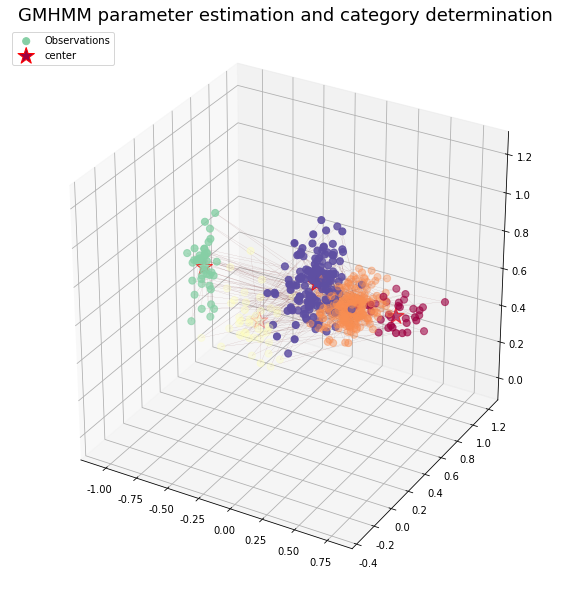

In [30]:
# 画图
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(8, 8), facecolor='w')
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.Spectral(np.linspace(0,1,n))
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=50, c=labels, cmap=plt.cm.Spectral, marker='o', label=u'Observations', depthshade=True)
plt.plot(sample[:, 0], sample[:, 1], sample[:, 2], lw=0.1, color='#A07070')
colors = plt.cm.Spectral(np.linspace(0, 1, n))
ax.scatter(means[:, 0], means[:, 1], means[:, 2], s=300, c=colors, edgecolor='r', linewidths=1, marker='*', label=u'center')

x_min, y_min, z_min = sample.min(axis=0)
x_max, y_max, z_max = sample.max(axis=0)
x_min, x_max = expand(x_min, x_max)
y_min, y_max = expand(y_min, y_max)
z_min, z_max = expand(z_min, z_max)
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout(1)
plt.title(u'GMHMM parameter estimation and category determination', fontsize=18)
plt.show()